## Spatial Data Science (GEO6119)

---

# Lab 7 (Part B): Point Pattern Analysis: Inferential Methods

In this lab, you will use inferential methods to analyze point patterns. Specifically, the following methods will be used:
- Nearest Neighbor Distance
- Reply's K-function


<br>
Instructor: Yi Qiang (qiangy@usf.edu)<br>


---

## 1. Import Libraries

Import some common libraries needed for this lab.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#set default plot size, you can adjust the [width, height] to make plots fit your screen size
plt.rcParams['figure.figsize'] = [10, 10]

# Limit items to be printed: save screen space
np.set_printoptions(threshold= 20)
pd.options.display.max_seq_items = 20

## 2. Read and Explore the Dataset

Read the dataset of Chicago liquor storesto a pandas DataFrame. This dataset was scraped from Google Maps in 2015 and published in [GeoDa's website](https://geodacenter.github.io/data-and-lab/liq_chicago/)

In [4]:
# Read the file into a DataFrame
df = pd.read_csv("other/chicago_stores.csv")

# Preview the DataFrame
df.head()

,Unnamed: 0.1,Unnamed: 0,STORE NAME,LICENSE ID,ACCOUNT NUMBER,SQUARE FEET,BUFFER SIZE,ADDRESS,ZIP CODE,COMMUNITY AREA NAME,COMMUNITY AREA,WARD,CENSUS TRACT,CENSUS BLOCK,LATITUDE,LONGITUDE,x,y
0,0,0,200 LIQUORS,48663.0,17055.0,5000.0,B,204 E 47TH ST,60653,GRAND BOULEVARD,38,3,17031381500,1.703140e+14,41.809424,-87.620952,448420.976744,4.628803e+06
1,1,1,3600 COMMISSARY,24279.0,9830.0,3800.0,B,3600 N LAKE SHORE DR,60613,LAKE VIEW,6,46,17031060900,1.703110e+14,41.948684,-87.643650,446651.529704,4.644279e+06
2,2,2,4343 PETES FRESH MARKET,1336669.0,260303.0,57000.0,A,4343 S PULASKI RD,60632,ARCHER HEIGHTS,57,14,17031570100,1.703160e+14,41.813914,-87.723665,439893.316250,4.629369e+06
3,3,3,4700 PETE'S FRESH MARKET,1243125.0,245519.0,45000.0,A,4700 S KEDZIE AVE,60632,BRIGHTON PARK,58,14,17031842800,1.703180e+14,41.808047,-87.704119,441511.464243,4.628704e+06
4,4,4,5659 W. DIVERSEY,1575023.0,277375.0,4000.0,B,5659 W DIVERSEY AVE,60639,BELMONT CRAGIN,19,30,17031190602,1.703120e+14,41.931135,-87.768612,436276.577581,4.642416e+06


The dataset stores two typess of coordinates. LATITUDE and LONGITUDE are geographic coordinates (epsg:4326). x and y are coordinates in the UTM zone 16N (epsg:32616), which covers the Chicago area.

Plot the liquor stores in a basemap.

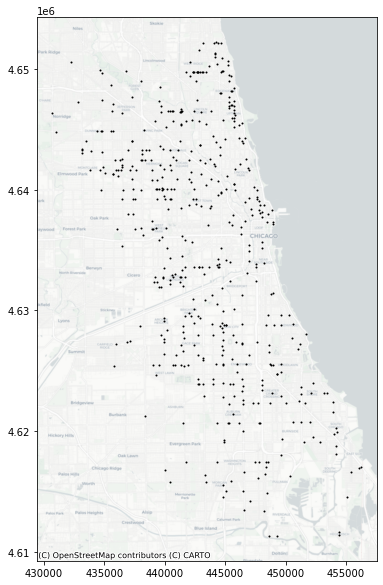

In [5]:
# Import contextily
import contextily as cx

# Create a canvas "ax2"
ax1 = plt.subplot()

# Generate scatter plot for the airbnb locations, using x and y as coordinates
ax1.scatter(x = df['x'], y = df['y'], color = 'black', s = 1)

# Add a basemap to the inner box (map) of the plot
cx.add_basemap(source = cx.providers.CartoDB.Positron, crs="EPSG:32616", ax = ax1)

The water body the study area may influence the store distribution (no store can be in the lake). So we select stores within a rectangle bounding box in the downtown area for the following analysis. The box's bottom-left coordinates are [-87.7449, 41.7220] and thetop-right cordinates are [-87.6247,41.8727]

In [6]:
df2 = df[(df['LATITUDE']> 41.721999) &(df['LATITUDE']<41.872709)&(df['LONGITUDE']> -87.744988) &(df['LONGITUDE']<-87.624699)]

Highlight the selected stores as red dots in a map.

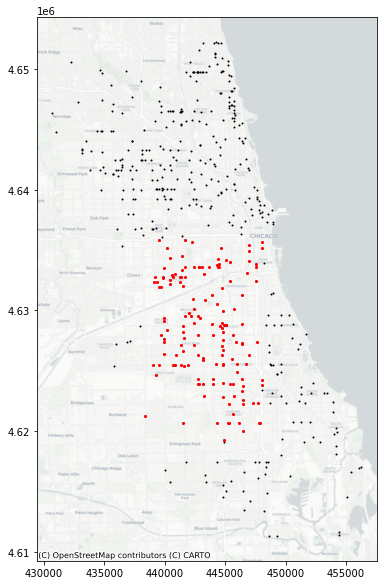

In [7]:
# Import contextily
import contextily as cx

# Create a canvas "ax2"
ax1 = plt.subplot()

# Generate scatter plot for the airbnb locations, using x and y as coordinates
ax1.scatter(x = df['x'], y = df['y'], color = 'black', s = 1)

# Generate scatter plot for the airbnb locations, using x and y as coordinates
ax1.scatter(x = df2['x'], y = df2['y'], color = 'red', s = 4)

# Add a basemap to the inner box (map) of the plot
cx.add_basemap(source = cx.providers.CartoDB.Positron, crs="EPSG:32616", ax = ax1)

## 3. Comparing Store Locations with CSR

First, we convert the x, y coordinates of the selected liquor stores into an array, as the functions for quadrat analysis takes arrays as input.

In [8]:
coordinates = df2[['x','y']].values

For illustration purpose, we simulate a point set from a known completely spatially random (CSR) process. That is, the location and number of points is totally random; there is neither clustering nor dispersion.

In [9]:
# Import neccesary functions from the pointpats library
from pointpats import distance_statistics, QStatistic, random, PointPattern, PoissonPointProcess

# Simulate a random pattern of the same number of points and spatial extent as liquor stores. 
random_pattern = random.poisson(coordinates, size=len(coordinates))

For comparison, we plot the random points (red x) and actual store locations in the same map.

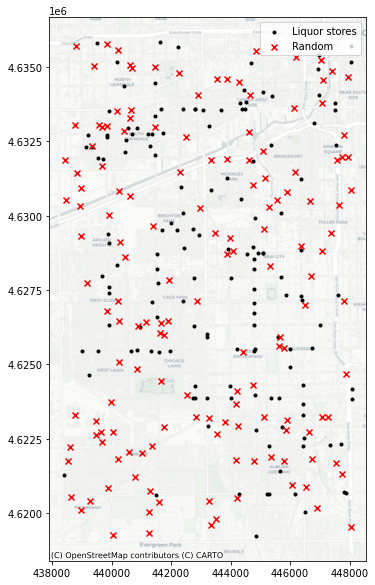

In [10]:
# Creating an empty canvas
ax3 = plt.subplot()

# Plot the store locations 
plt.scatter(*coordinates.T, color='k', marker='.', label='Liquor stores')

# Plot random points
plt.scatter(*random_pattern.T, color='r', marker='x', label='Random')

# Add a basemap
cx.add_basemap(
    ax = ax3, 
    source=cx.providers.CartoDB.Positron,
    crs="EPSG:32616"
)

# Add a legend on the top-right position
ax3.legend(ncol=1, loc='upper right')

Observing the above map, we can somehow tell the store distribution does not follow CSR (some areas have a higher density). But we need to confirm this using statistic methods.

## 4. Quadrat Count Analysis

Quadrat statistics examine the spatial distribution of points in an area in terms of the count of observations that fall within a given cell (quadrat). By comparing the actual point count and expected point count in each quadrat, the analysis examine the evenness of the point distribution. 

We will use the `Qstatistic` function in the `pointpats` library to conduct quadrat count analysis for the store locations. Documentation of QStatistic can be found [here](https://pointpats.readthedocs.io/en/latest/generated/pointpats.QStatistic.html).

First, we create quadrats in 5 rows and 5 columns to partition the space. nx and ny are parameters to control the number (size) of quadrats.

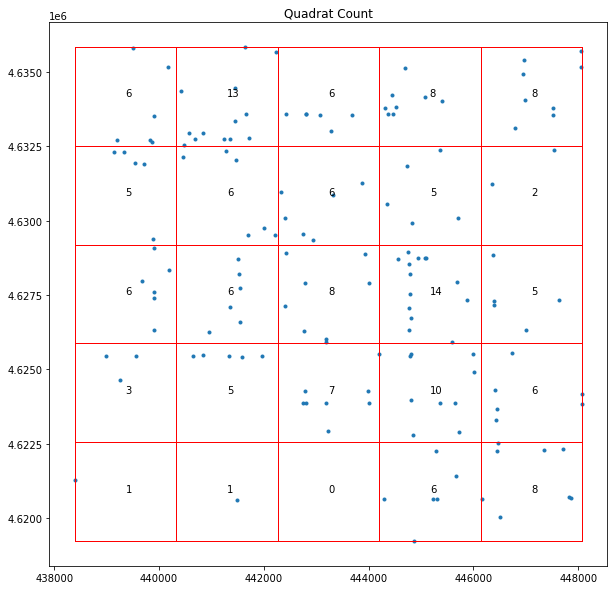

In [11]:
qstat = QStatistic(pp = coordinates, nx = 5, ny = 5)
qstat.plot()

Then we create quadrats for the random point set.

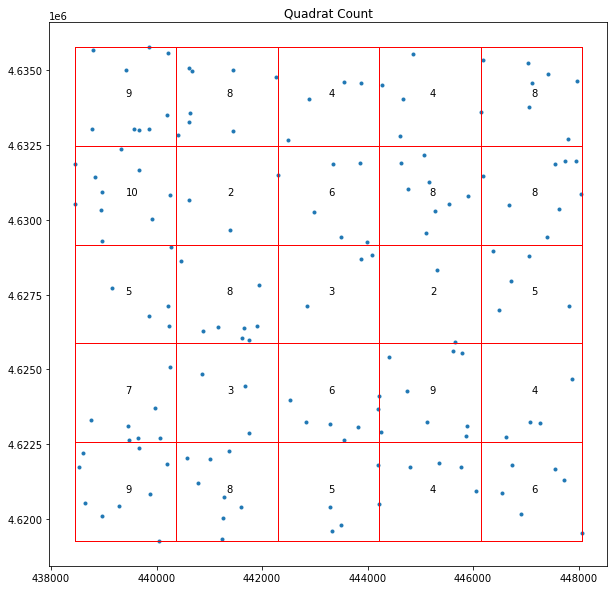

In [12]:
qstat_ran = QStatistic(pp = random_pattern, nx = 5, ny = 5)
qstat_ran.plot()

Print the <i>p</i> values of the store locations and the simulated random point set.

In [13]:
print('p value of actual store locations:' + str(qstat.chi2_pvalue))
print('p value of random points:' + str(qstat_ran.chi2_pvalue))

p value of actual store locations:0.009423721058505745
p value of random points:0.5390155538533516


### Question 1 (1pt): Please interpret the meaning of <i>p</i> values of the two point patterns. 

The first p-value is 0.009, indicating that 0.9% probability that the liquor stores are randomly distributed. In other words, it is 99.1% probability the store locations are not random, meaning it's clustered.

The second p-value is 0.937, indicating that 93.7% probability the points are randomly distributed. In other words, it is 6.3% probability that the points are not random.


## 5. Nearest Neighbor Distance

Nearest-Neighbor Distance (NND) is the distance between a point and its closest neighboring point. The mean of NND between all point pairs is used as a global indicator to measure the overall pattern of a point set (Clark & Evans, 1954). The mean NND of a given point collection can be compared with the expected NND from points following complete spatial randomness (CSR) to test the significance of the pattern (e.g., how clustered or dispersed the point pattern is).

In [30]:
# Conver the array of x, y coordintates to a PointPattern object
liquor_pp = PointPattern(coordinates)

Print the nearest neighbor distance (NND) of each point

In [34]:
liquor_pp.nnd

array([[273.54457141],
       [511.02874808],
       [389.70710115],
       ...,
       [  0.        ],
       [796.91007611],
       [247.26442608]])

Use the `mean_nnd` function to return the mean NND

In [35]:
liquor_pp.mean_nnd

494.13997049450865

You can also calculate the mean NND from the NND array. The result is the same.

In [36]:
liquor_pp.nnd.mean()

494.13997049450865

Next, we compare the mean NND of the liquor stores `pp` with the distribution of NNDs of some random point sets. We first simulate 1000 random point sets. Each point set contain the same number of points as `pp` and within the same. It's like we through a number of stones for 1000 times.

In [37]:
csr_process = PoissonPointProcess(window = liquor_pp.window, n = liquor_pp.n, samples = 1000, asPP=True) 
csr_real = csr_process.realizations

Print the 10th point set

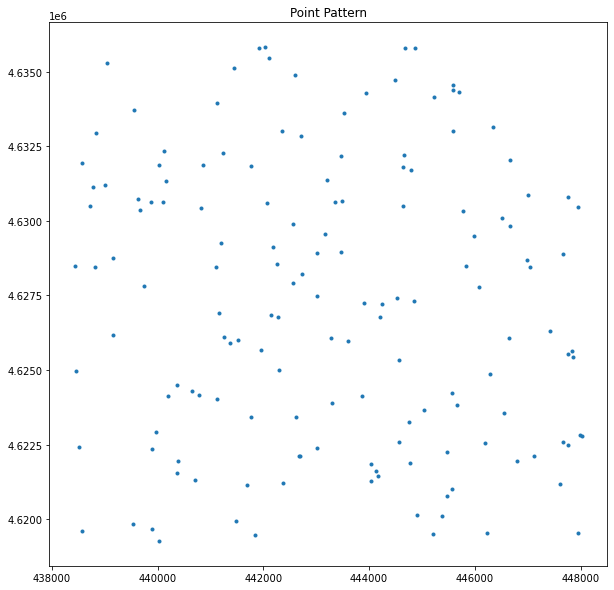

In [38]:
csr_real[9].plot()

Print the mean nnd of the 10th point set

In [39]:
csr_real[9].mean_nnd

528.1798679260907

`csr_real` is in a dictionary data type. We convert it into a data frame

In [40]:
# Conver csr_real to a dataframe 'csr_df'
csr_df = pd.DataFrame(csr_real.items(),columns=['ID','Points'])

# Print csr_df
csr_df

,ID,Points
0,0,<pointpats.pointpattern.PointPattern object at...
1,1,<pointpats.pointpattern.PointPattern object at...
2,2,<pointpats.pointpattern.PointPattern object at...
3,3,<pointpats.pointpattern.PointPattern object at...
4,4,<pointpats.pointpattern.PointPattern object at...
...,...,...
995,995,<pointpats.pointpattern.PointPattern object at...
996,996,<pointpats.pointpattern.PointPattern object at...
997,997,<pointpats.pointpattern.PointPattern object at...
998,998,<pointpats.pointpattern.PointPattern object at...


Next, we get the mean NNDs of the 1000 simulated point sets. 

In [41]:
# Store the mean nnds of the 100 point sets in a list 'mean_nnd_ls' 
csr_nnd_ls = csr_df['Points'].apply(lambda x : x.mean_nnd)

# Print mean_nnd_ls
csr_nnd_ls

0      547.567379
1      566.316455
2      543.957238
3      531.345824
4      556.130297
          ...    
995    563.149570
996    532.832968
997    572.848623
998    535.509465
999    571.874297
Name: Points, Length: 1000, dtype: float64

Calculate and print the mean and standard deviation of NNDs of the 1000 random point sets.

In [42]:
csr_mean = np.mean(csr_nnd_ls)
csr_std = np.std(csr_nnd_ls)

print('Mean NNDs of 1000 random point sets is: '+str(csr_mean))
print('Standard deviation of NNDs of 1000 random point sets is: '+str(csr_std))

Mean NNDs of 1000 random point sets is: 535.088140573291
Standard deviation of NNDs of 1000 random point sets is: 24.174767018868184


Print the mean NND of the Chicago liquor stores

In [44]:
print('The mean NND of Chicago liquor store is '+ str(liquor_pp.mean_nnd))

The mean NND of Chicago liquor store is 494.13997049450865


Next, we create histograms of the mean NNDs of the 1000 random point sets, with a few line markers:
- Black line is the mean of the distribution.
- Blue dashed lines are +/-1 standard deviation from the mean.
- Blue dashed lines lines are +/-1 standard deviation from the mean.
- Red line is the mean NND of Chicago stores.

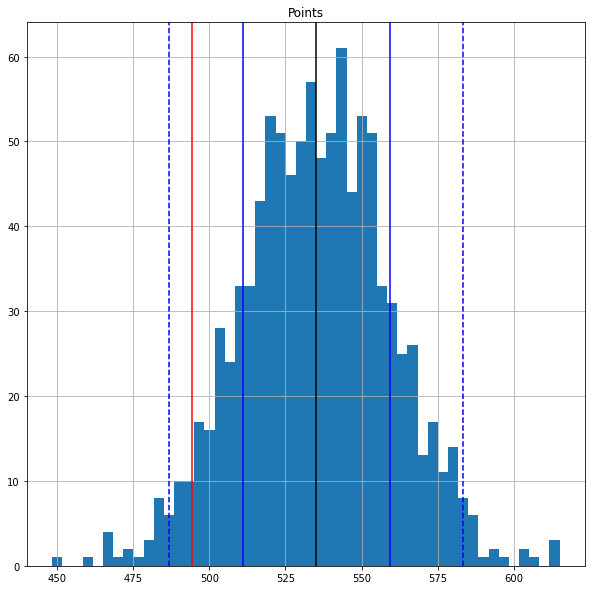

In [45]:
# Create histogram of mean NNDs of the 1000 random point sets
pd.DataFrame(csr_nnd_ls).hist(bins=50)

# Create black line for mean of the mean NNDs of the 1000 random point sets
plt.axvline([csr_mean-2*csr_std], color='b',linestyle = '--')

# Create blue lines for +/-1 standard deviation
plt.axvline([csr_mean-1*csr_std], color='b')
plt.axvline([csr_mean+csr_std], color='b')

# Create blue dashed lines for +/-2 standard deviations
plt.axvline([csr_mean], color='black')
plt.axvline([csr_mean+2*csr_std], color='b',linestyle = '--')

# Create red line for the mean NND of Chicago Liquor stores
plt.axvline([liquor_pp.mean_nnd], color='r')

The mean NNDs of the 1000 random point sets generally follows a normal distribution, where 99.5% of the NNDs are between the two blue dashed lines (-2 st. dev. and +2 st. dev.). Less than 5% of NNDs are outside of the +/-2 st. dev. range.

<img src="https://raw.githubusercontent.com/qiang-yi/spatial_data_science/df7582ce65641fbcd7a44745ec7c47ff7ee4baa9/image/wk9/normal.jpg" width=800)>

We can further compute the z-score and p value of the NND of Chicago liquor stores.

In [46]:
import scipy
# calculate z score
z_score = (liquor_pp.mean_nnd-csr_mean)/csr_std 

#Calculate p value of a two-tailed test
p_value = scipy.stats.norm.sf(abs(z_score))*2 

print('Z score of the NND of Chicago liquor stores is '+ str(z_score))
print('p value of the NND of Chicago liquor stores is '+ str(p_value))

Z score of the NND of Chicago liquor stores is -1.6938392848552641
p value of the NND of Chicago liquor stores is 0.0902958268014917


### Question 2: Please try to interpret the above results. Please explain 1) what type of pattern are the Chicago liquor stores, and 2) what is the probability the stores are not randomly distributed.

From the perspective of NND, the liquor stores tend to clustered (z<0) but the clustering pattern is not significant (p>0.05). There is still 8.3% probability that the store distribution is from a Complete Spatial Randomness (CSR). Based on the confidence level of p<0.05, the p-value is not low enough to reject the null hypothesis (random pattern).

## 6. K-Function

Ripley's K-function recursively counts the number of points in the circle around each points with the increasing radius r. Instead of a single statistic, K-function uses a line chart to describe the point pattern at different radii, so it may show the changing pattern at different scales (different radii). 

K-function of an observed point set can be compared with the K-function of random point sets (CSR):
- Drifting under the CSR line: disperse
- Drifting above the CSR line: clustered

<img src="https://raw.githubusercontent.com/qiang-yi/spatial_data_science/df7582ce65641fbcd7a44745ec7c47ff7ee4baa9/image/wk9/k.jpg" width=500 align='left'>


Use the `distance_statistics.Kenv` function to plot the K-function of Chicago liquor stores and the K-function of a random point set.

- Blue line (K) is the K-function of Chicago liquor stores
- Green dashed line is the mean K-function of 1000 random point sets
- Red dashed lines are 95% upper and lower confidence interval of K-functions of random point sets.

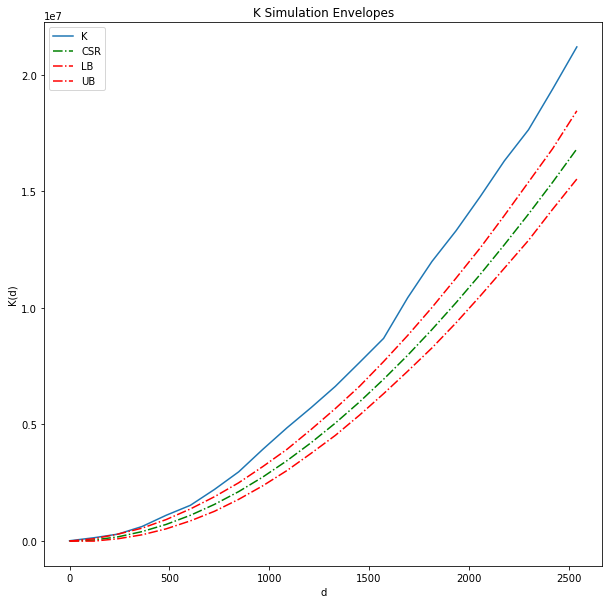

In [47]:
k_env = distance_statistics.Kenv(liquor_pp, intervals=20, realizations=csr_process)

k_env.plot()

### Question 3: Please interpret the K-function of Chicago liquor stores.

The K-function of the liquor stores is always above the 95% confidence interval of the K-function of CSR. It means the liquor stores are in a clustering pattern when measured at all scales.